# Lab6: Classification 2 (Decision Tree, Ensemble Methods)

*Note: This lab session is graded. Complete all the exercises and submit the ipynb to canvas under assignment Lab6: Decision Tree and Ensemble Methods by **Friday (02/17), 11:59 PM***

*Also Note:* Assignment 4 : Supervised Classification-2 will be posted tonight. **Deadline is Friday (02/24), 11:59 PM**

## Today's Tasks: 
1. We are going to continue supervised classification with Diabetes Data
2. Process Diabetes Dataset for supervised classification. This includes loading the data, scaling features
3. Split and form test dataset
4. Use the rest of the data for 5-fold cross validation
5. Train and cross validate the following classifiers
    - Logistic Regression (default)
    - Support Vector Classifier (default)
    - Decision Tree
    - Random Forest
    - GradientBoostingClassifier
    - VotingClassifier
6. Compute mean Cross Validation accuracies and select the best model based on it
7. Compute the test accuracy of the best model
8. Feature ablation:
    - Leave one feature out at a time and cross validate your best model
    - Rank your features based on ablation accuracy drop

## 0. The Diabetes Dataset
We are using the same dataset from last lab, which has the following columns

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

## 1. Load and Preprocess Data
Let's load the data into a Pandas DataFrame. Check and remove duplicates. Check and clean rows with NULL entries. 

In [24]:
# Use the following two lines if you face issues in printing dataframes using the head() method
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy

diabetes_df = pd.read_csv("Lab5_Diabetes.csv")
diabetes_df = diabetes_df.drop_duplicates()


# We will now apply dropna()
diabetes_df = diabetes_df.dropna()
print (f"Shape of data {diabetes_df.shape}")
diabetes_df.head()

Shape of data (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1.1. Feature Engineering
None of the features appear to be categorical. We will just treat everything as numerical. Let's separate the features and labels columns

In [25]:
diabetes_features_df = diabetes_df.iloc[:,:-1]
diabetes_labels_df = diabetes_df[["Outcome"]]

diabetes_features_df.head()
diabetes_labels_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


,Outcome
0,1
1,0
2,1
3,0
4,1


Let's scale features using Standard scaling.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_columns = diabetes_features_df.columns

diabetes_features_df[all_columns] = scaler.fit_transform(diabetes_features_df[all_columns])
diabetes_features_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


## 2. Evaluation Metric - Accuracy

We will use accuracy as our eveluation criterion.

$$acc = \frac{Number~of~times~(predicted~class~=~actual~class)}{Total~number~of~examples}$$

## 3. Initializing our classifiers
Let's instantiate our classifiers, namely, 
- Logistic Regression (default)
- Support Vector Classifier (default)
- Decision Tree
- Random Forest
- GradientBoostingClassifier
- VotingClassifier (let's combine decisions from the first three classifiers)

We will cross validate with k=5 throughout. 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier


lr_vanilla = LogisticRegression(penalty=None) # OR penalty="none" depending on your sklearn version
svm_linear = SVC(kernel="linear")
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=23) # some random seed for reproducibility
grad_boost = GradientBoostingClassifier()
voting = VotingClassifier(estimators=[("1",lr_vanilla),("2",svm_linear),("3",dt)])

all_models = {"lr":lr_vanilla, 
              "svm":svm_linear,
              "decision_tree":dt,
              "random_forest":rf,
              "grad_boost":grad_boost,
              "voting":voting}

print (f"We are working with classifiers {all_models.keys()}")

We are working with classifiers dict_keys(['lr', 'svm', 'decision_tree', 'random_forest', 'grad_boost', 'voting'])


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# First extract our test data and store it in x_test, y_test
features = diabetes_features_df.to_numpy()
labels = diabetes_labels_df.to_numpy()
_x, x_test, _y, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

k = 5 # 5-fold

# We can use sklearn's cross validation score directly
# We can speed up training using n_jobs parameter which specifies how many cpu_cores to use

best_model_name = ""
best_model_valid_accuracy = 0
best_model = None

for model_name in all_models.keys():
    model = all_models[model_name]
    cv_scores = cross_val_score(model,_x,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy for model {model_name} = {average_cv_score}")

    if average_cv_score > best_model_valid_accuracy :
        best_model_name = model_name
        best_model_valid_accuracy  = average_cv_score
        best_model = model

print (f"Best model is {best_model_name} with {k}-fold accuracy of {best_model_valid_accuracy}")

Mean cross validation accuracy for model lr = 0.7670003127932438
Mean cross validation accuracy for model svm = 0.7669898863517881
Mean cross validation accuracy for model decision_tree = 0.733698258784277
Mean cross validation accuracy for model random_forest = 0.7684078823897403
Mean cross validation accuracy for model grad_boost = 0.7728182671254301
Mean cross validation accuracy for model voting = 0.7670003127932437
Best model is grad_boost with 5-fold accuracy of 0.7728182671254301


## 4. Testing accuracy
Let's print the testing accuracy

In [29]:
from sklearn.metrics import accuracy_score

# Let's fit the best model again with train+valid data
# This is the model we are gonna ship/deploy to practice

best_model.fit(_x,_y.flatten())

y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_pred_test, y_test.flatten())

print (f"Test accuracy for model {test_accuracy}")

GradientBoostingClassifier()

Test accuracy for model 0.7272727272727273


## 5. Feature Ranking - Ablation Test

Ablation tests are models dependent ways to assess feature importance and rank features based on their importance. 

We skip one feature at a time and run our k-fold validation for a model of our choice to examine how much impact does droping that feature have on the overall accuracy

In [30]:
# Let's run ablation tests on our best model
# You could choose any model to do this test
best_model = GradientBoostingClassifier()

feature_names = diabetes_features_df.columns

# Let's maintain an accuracy dictionary

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")
    
    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = numpy.delete(_x,i,axis=1) # axis = 1 means columns
    
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = best_model_valid_accuracy-average_cv_score

Removing feature Pregnancies
Mean cross validation accuracy = 0.7756542592013346
Removing feature Glucose
Mean cross validation accuracy = 0.7235637576895005
Removing feature BloodPressure
Mean cross validation accuracy = 0.7568970910228339
Removing feature SkinThickness
Mean cross validation accuracy = 0.7670420185590657
Removing feature Insulin
Mean cross validation accuracy = 0.7699092899593368
Removing feature BMI
Mean cross validation accuracy = 0.7626837660306538
Removing feature DiabetesPedigreeFunction
Mean cross validation accuracy = 0.7742466896048379
Removing feature Age
Mean cross validation accuracy = 0.7496819935356063


### 5.1. Plotting accuracies after ablation test

We can plot accuracy-vs-features graph. Which form of visualization do we need? bar-graph?

<BarContainer object of 9 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'No ablation'),
  Text(1, 0, 'Pregnancies'),
  Text(2, 0, 'Glucose'),
  Text(3, 0, 'BloodPressure'),
  Text(4, 0, 'SkinThickness'),
  Text(5, 0, 'Insulin'),
  Text(6, 0, 'BMI'),
  Text(7, 0, 'DiabetesPedigreeFunction'),
  Text(8, 0, 'Age')])

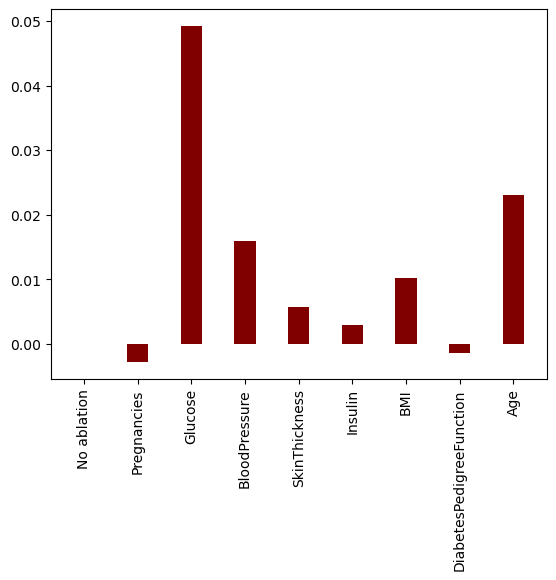

In [31]:
from matplotlib import pyplot as plt

plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")

### 5.2. Or let's just sort and print the features

In [32]:
def criteria(l):
    return l[1]

sorted_accs =  sorted(accuracy_drop_log.items(),key=criteria, reverse=True)

print (f"Features are ranked from best to worst (based on how removing them impacts the accuracy of {best_model_name})")
print (f"**************************************")

i=1
for entry in sorted_accs:
    feature_name = entry[0]
    acc_drop = entry[1]
    
    # We do not want to print "No ablation"
    if feature_name != "No ablation":
        print (f"Feature {i}.{feature_name}, drop in acc {acc_drop}")
        i=i+1


Features are ranked from best to worst (based on how removing them impacts the accuracy of grad_boost)
**************************************
Feature 1.Glucose, drop in acc 0.04925450943592957
Feature 2.Age, drop in acc 0.02313627358982384
Feature 3.BloodPressure, drop in acc 0.015921176102596246
Feature 4.BMI, drop in acc 0.010134501094776316
Feature 5.SkinThickness, drop in acc 0.005776248566364384
Feature 6.Insulin, drop in acc 0.002908977166093285
Feature 7.DiabetesPedigreeFunction, drop in acc -0.001428422479407776
Feature 8.Pregnancies, drop in acc -0.002835992075904459


**Insights:** As seen, factors like Glucose, Age, BloodPressure, BMI are better  predictors than DiabetesPedigreeFunction or Pregnancies based on our dataset and chosen model

## E1. Exercise: Perform ablation test for three other models

Perform ablation test using the following three models (one by one) as your models of choice:

- Logistic Regression 
- SVC (linear kernel)
- Decision Tree

Basically, you will have to repeat section 5 thrice and obtain three feature rankings for the above three models. What are the feature rankings that you are getting? 

Is there a general consensus among the models that certain features are always ranked higher? 

Can you manually come up with a final ranking of features based on the 4 ranked lists of features (one from section 5 and three from your exercise)?

In [33]:
# We re-do 5.0 - with a decision tree classifier
best_model = DecisionTreeClassifier()

feature_names = diabetes_features_df.columns

# Let's maintain an accuracy dictionary

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")
    
    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = numpy.delete(_x,i,axis=1) # axis = 1 means columns
    
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = best_model_valid_accuracy-average_cv_score

Removing feature Pregnancies
Mean cross validation accuracy = 0.7206652069648629
Removing feature Glucose
Mean cross validation accuracy = 0.6585340423313524
Removing feature BloodPressure
Mean cross validation accuracy = 0.706203732666041
Removing feature SkinThickness
Mean cross validation accuracy = 0.7380356584297779
Removing feature Insulin
Mean cross validation accuracy = 0.7308309873840059
Removing feature BMI
Mean cross validation accuracy = 0.7032947554999478
Removing feature DiabetesPedigreeFunction
Mean cross validation accuracy = 0.7091231362735899
Removing feature Age
Mean cross validation accuracy = 0.6802627463246794


<BarContainer object of 9 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'No ablation'),
  Text(1, 0, 'Pregnancies'),
  Text(2, 0, 'Glucose'),
  Text(3, 0, 'BloodPressure'),
  Text(4, 0, 'SkinThickness'),
  Text(5, 0, 'Insulin'),
  Text(6, 0, 'BMI'),
  Text(7, 0, 'DiabetesPedigreeFunction'),
  Text(8, 0, 'Age')])

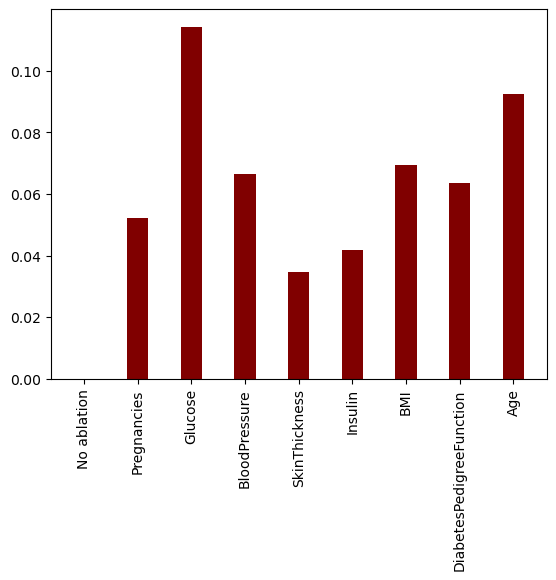

In [34]:
# plotting
plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")

In [35]:
# or do this
def criteria(l):
    return l[1]

sorted_accs =  sorted(accuracy_drop_log.items(),key=criteria, reverse=True)

print (f"Features are ranked from best to worst (based on how removing them impacts the accuracy of {best_model_name})")
print (f"**************************************")

i=1
for entry in sorted_accs:
    feature_name = entry[0]
    acc_drop = entry[1]
    
    # We do not want to print "No ablation"
    if feature_name != "No ablation":
        print (f"Feature {i}.{feature_name}, drop in acc {acc_drop}")
        i=i+1

Features are ranked from best to worst (based on how removing them impacts the accuracy of grad_boost)
**************************************
Feature 1.Glucose, drop in acc 0.11428422479407774
Feature 2.Age, drop in acc 0.09255552080075069
Feature 3.BMI, drop in acc 0.06952351162548231
Feature 4.BloodPressure, drop in acc 0.06661453445938914
Feature 5.DiabetesPedigreeFunction, drop in acc 0.0636951308518402
Feature 6.Pregnancies, drop in acc 0.0521530601605672
Feature 7.Insulin, drop in acc 0.041987279741424244
Feature 8.SkinThickness, drop in acc 0.034782608695652195


We have some difference in our data. The DecisionTree Classifier does not seem to be as accurate as the gradient booster classifer.

We will go with classifer 2: SVC

In [36]:
# We re-do 5.0 again - with a voting classifier
best_model = SVC(kernel='linear')

feature_names = diabetes_features_df.columns

# Let's maintain an accuracy dictionary

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")
    
    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = numpy.delete(_x,i,axis=1) # axis = 1 means columns
    
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = best_model_valid_accuracy-average_cv_score

Removing feature Pregnancies
Mean cross validation accuracy = 0.7727869878010635
Removing feature Glucose
Mean cross validation accuracy = 0.6917109790428527
Removing feature BloodPressure
Mean cross validation accuracy = 0.7640913356271506
Removing feature SkinThickness
Mean cross validation accuracy = 0.7684391617141071
Removing feature Insulin
Mean cross validation accuracy = 0.7698884370764258
Removing feature BMI
Mean cross validation accuracy = 0.7510478573662809
Removing feature DiabetesPedigreeFunction
Mean cross validation accuracy = 0.7583046606193307
Removing feature Age
Mean cross validation accuracy = 0.7611927849025129


<BarContainer object of 9 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'No ablation'),
  Text(1, 0, 'Pregnancies'),
  Text(2, 0, 'Glucose'),
  Text(3, 0, 'BloodPressure'),
  Text(4, 0, 'SkinThickness'),
  Text(5, 0, 'Insulin'),
  Text(6, 0, 'BMI'),
  Text(7, 0, 'DiabetesPedigreeFunction'),
  Text(8, 0, 'Age')])

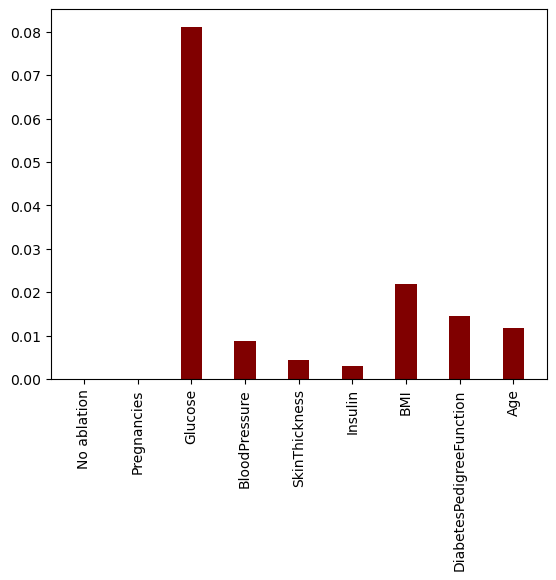

In [37]:
# plotting
plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")

In [38]:
# or do this
def criteria(l):
    return l[1]

sorted_accs =  sorted(accuracy_drop_log.items(),key=criteria, reverse=True)

print (f"Features are ranked from best to worst (based on how removing them impacts the accuracy of {best_model_name})")
print (f"**************************************")

i=1
for entry in sorted_accs:
    feature_name = entry[0]
    acc_drop = entry[1]
    
    # We do not want to print "No ablation"
    if feature_name != "No ablation":
        print (f"Feature {i}.{feature_name}, drop in acc {acc_drop}")
        i=i+1

Features are ranked from best to worst (based on how removing them impacts the accuracy of grad_boost)
**************************************
Feature 1.Glucose, drop in acc 0.08110728808257739
Feature 2.BMI, drop in acc 0.021770409759149234
Feature 3.DiabetesPedigreeFunction, drop in acc 0.014513606506099452
Feature 4.Age, drop in acc 0.01162548222291726
Feature 5.BloodPressure, drop in acc 0.008726931498279522
Feature 6.SkinThickness, drop in acc 0.0043791054113230254
Feature 7.Insulin, drop in acc 0.0029298300490042672
Feature 8.Pregnancies, drop in acc 3.127932436663983e-05


So this seems a little more accurate but not so much more accurate than before.

Now we do the third model selected: Logistic Regression

In [39]:
# We re-do 5.0 again - with a voting classifier
best_model = LogisticRegression()

feature_names = diabetes_features_df.columns

# Let's maintain an accuracy dictionary

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")
    
    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = numpy.delete(_x,i,axis=1) # axis = 1 means columns
    
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = best_model_valid_accuracy-average_cv_score

Removing feature Pregnancies
Mean cross validation accuracy = 0.7670107392346992
Removing feature Glucose
Mean cross validation accuracy = 0.7047544573037222
Removing feature BloodPressure
Mean cross validation accuracy = 0.7684391617141071
Removing feature SkinThickness
Mean cross validation accuracy = 0.7699092899593369
Removing feature Insulin
Mean cross validation accuracy = 0.7670315921176103
Removing feature BMI
Mean cross validation accuracy = 0.7640913356271505
Removing feature DiabetesPedigreeFunction
Mean cross validation accuracy = 0.7655614638723803
Removing feature Age
Mean cross validation accuracy = 0.7670003127932438


<BarContainer object of 9 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'No ablation'),
  Text(1, 0, 'Pregnancies'),
  Text(2, 0, 'Glucose'),
  Text(3, 0, 'BloodPressure'),
  Text(4, 0, 'SkinThickness'),
  Text(5, 0, 'Insulin'),
  Text(6, 0, 'BMI'),
  Text(7, 0, 'DiabetesPedigreeFunction'),
  Text(8, 0, 'Age')])

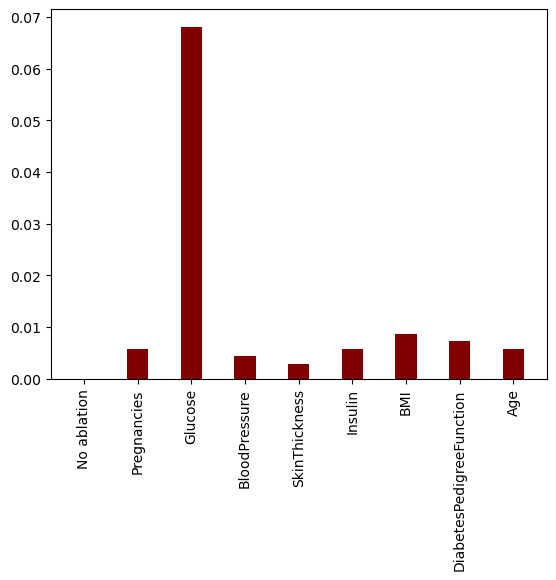

In [41]:
# plotting
plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")

In [42]:
# or do this
def criteria(l):
    return l[1]

sorted_accs =  sorted(accuracy_drop_log.items(),key=criteria, reverse=True)

print (f"Features are ranked from best to worst (based on how removing them impacts the accuracy of {best_model_name})")
print (f"**************************************")

i=1
for entry in sorted_accs:
    feature_name = entry[0]
    acc_drop = entry[1]
    
    # We do not want to print "No ablation"
    if feature_name != "No ablation":
        print (f"Feature {i}.{feature_name}, drop in acc {acc_drop}")
        i=i+1

Features are ranked from best to worst (based on how removing them impacts the accuracy of grad_boost)
**************************************
Feature 1.Glucose, drop in acc 0.0680638098217079
Feature 2.BMI, drop in acc 0.008726931498279633
Feature 3.DiabetesPedigreeFunction, drop in acc 0.007256803253049782
Feature 4.Age, drop in acc 0.005817954332186348
Feature 5.Pregnancies, drop in acc 0.0058075278907309125
Feature 6.Insulin, drop in acc 0.005786675007819819
Feature 7.BloodPressure, drop in acc 0.0043791054113230254
Feature 8.SkinThickness, drop in acc 0.002908977166093174


### WHAT ARE THE TOP 4 FEATURES?

NUMBER 1: GLUCOSE

NUMBER 2: BMI (From LogisticRegression and SVC)

NUMBER 3: Age

NUMBER 4: DiabetesPedigreeFunction (barely)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f501a8e-f6e4-43a9-b4a2-6516b2e3d333' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>